# 학습 목표
1. SMILES 표현법 이해 및 분자 생성 모델의 기본 원리 학습
2. LSTM 기반 SMILES 생성 모델 구현
3. 생성된 분자의 유효성 및 특성 검증

# 1. SMILES와 분자 생성 모델
1. **LSTM/RNN 기반 모델**
   - 텍스트 생성과 유사한 방식으로 SMILES 문자열 생성
   - 예: 본 강의에서 구현할 모델

2. **VAE(Variational Autoencoder) 기반 모델**
   - SMILES를 잠재 공간에 매핑하고 새로운 분자 생성
   - 예: Chemical VAE, GVAE

3. **GAN(Generative Adversarial Network) 기반 모델**
   - 생성자와 판별자 네트워크를 통한 SMILES 생성
   - 예: MolGAN

4. **Transformer 기반 모델**
   - 자기 주의 메커니즘을 활용한 SMILES 생성
   - 예: MolFormer


Arús-Pous, J., Patronov, A., Bjerrum, E. J., Tyrchan, C., Reymond, J. L., Chen, H., & Engkvist, O. (2020). SMILES-based deep generative scaffold decorator for de-novo drug design. Journal of cheminformatics, 12, 1-18.

https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00441-8

<img src='https://media.springernature.com/lw685/springer-static/image/art%3A10.1186%2Fs13321-020-00441-8/MediaObjects/13321_2020_441_Fig11_HTML.png'>

# 2. 실습

## 2.1. 라이브러리 설치 및 불러오기

In [ ]:
# 필요한 라이브러리 설치
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 26.4 MB/s eta 0:00:00


In [ ]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, Lipinski
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import re
from tqdm import tqdm
import random
import os
import io
from collections import Counter

# 시각화 설정
plt.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 장치: {device}")

사용 중인 장치: cuda


## 2.2. 데이터 다운로드 및 전처리

In [ ]:
# 데이터 다운로드
!wget https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv

# 데이터 불러오기
data = pd.read_csv('250k_rndm_zinc_drugs_clean_3.csv')
print(f"데이터 크기: {data.shape}")
print("\n데이터 샘플:")
data.head()

--2025-03-29 17:54:23--  https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22606589 (22M) [text/plain]
Saving to: ‘250k_rndm_zinc_drugs_clean_3.csv.1’

250k_rndm_zinc_drug 100%[===================>]  21.56M  --.-KB/s    in 0.1s    

2025-03-29 17:54:23 (205 MB/s) - ‘250k_rndm_zinc_drugs_clean_3.csv.1’ saved [22606589/22606589]

데이터 크기: (249455, 4)

데이터 샘플:


,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182



총 SMILES 수: 249455


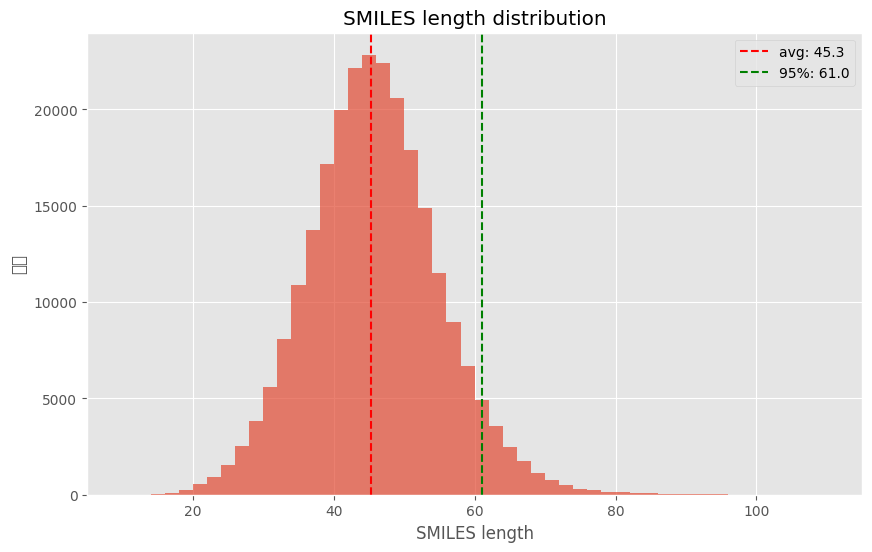

In [ ]:
# SMILES 열만 추출
smiles_list = data['smiles'].tolist()

# 데이터 분석
print(f"\n총 SMILES 수: {len(smiles_list)}")

# SMILES 길이 분포 확인
smiles_length = [len(s) for s in smiles_list]
plt.figure(figsize=(10, 6))
plt.hist(smiles_length, bins=50, alpha=0.7)
plt.xlabel('SMILES length')
plt.ylabel('빈도')
plt.title('SMILES length distribution')
plt.axvline(x=np.mean(smiles_length), color='r', linestyle='--', label=f'avg: {np.mean(smiles_length):.1f}')
plt.axvline(x=np.percentile(smiles_length, 95), color='g', linestyle='--', label=f'95%: {np.percentile(smiles_length, 95):.1f}')
plt.legend()
plt.show()

In [ ]:
# SMILES 문자 분석
all_chars = ''.join(smiles_list)
char_freq = Counter(all_chars)
print("\nSMILES에 사용된 문자 및 빈도:")
for char, freq in sorted(char_freq.items(), key=lambda x: x[1], reverse=True):
    print(f"'{char}': {freq}")

# 문자 집합 생성
chars = sorted(list(set(all_chars)))
print(f"\n총 고유 문자 수: {len(chars)}")
print(f"문자 집합: {''.join(chars)}")

# SMILES 전처리 함수
def preprocess_smiles(smiles_list, max_length=None):
    """SMILES 문자열 목록을 전처리합니다."""
    # 모든 SMILES에 시작, 종료 토큰 추가
    processed_smiles = ['<' + s + '>' for s in smiles_list]

    # 최대 길이가 지정되지 않은 경우 계산
    if max_length is None:
        max_length = max([len(s) for s in processed_smiles])

    # 문자를 인덱스로 매핑
    all_chars = set(''.join(processed_smiles))
    char_to_idx = {c: i for i, c in enumerate(sorted(list(all_chars)))}
    idx_to_char = {i: c for c, i in char_to_idx.items()}

    return processed_smiles, max_length, char_to_idx, idx_to_char

# SMILES 전처리
processed_smiles, max_length, char_to_idx, idx_to_char = preprocess_smiles(smiles_list)
vocab_size = len(char_to_idx)

print(f"전처리 후 최대 SMILES 길이: {max_length}")
print(f"어휘 크기: {vocab_size}")


SMILES에 사용된 문자 및 빈도:
'c': 2208615
'C': 2089128
'(': 963256
')': 963256
'1': 724634
'O': 545243
'2': 471673
'N': 437069
'=': 395685
'[': 344326
']': 344326
'@': 334570
'H': 290127
'n': 268134
'
': 249455
'3': 167094
'F': 79430
'+': 76813
'S': 63791
'-': 63514
'l': 42872
's': 39088
'o': 30988
'4': 30704
'/': 28558
'#': 15587
'B': 12722
'r': 12722
'\': 5838
'5': 2582
'I': 888
'P': 127
'6': 96
'7': 8
'8': 2

총 고유 문자 수: 35
문자 집합: 
#()+-/12345678=@BCFHINOPS[\]clnors
전처리 후 최대 SMILES 길이: 112
어휘 크기: 37


In [ ]:
# PyTorch 데이터셋 클래스 정의
class SMILESDataset(Dataset):
    def __init__(self, smiles_list, char_to_idx, max_length):
        self.smiles_list = smiles_list
        self.char_to_idx = char_to_idx
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        smile = self.smiles_list[idx]

        # 패딩
        padded_smile = smile.ljust(self.max_length)

        # 입력 시퀀스 (마지막 문자 제외)
        input_seq = [self.char_to_idx.get(c, 0) for c in padded_smile[:-1]]
        input_tensor = torch.tensor(input_seq, dtype=torch.long)

        # 출력 시퀀스 (첫 번째 문자 제외)
        target_seq = [self.char_to_idx.get(c, 0) for c in padded_smile[1:]]
        target_tensor = torch.tensor(target_seq, dtype=torch.long)

        return input_tensor, target_tensor

In [ ]:
# 샘플 크기 조정 (메모리 제한 고려)
sample_size = 10000  # 사용할 샘플 수
indices = np.random.choice(len(smiles_list), sample_size, replace=False)
sampled_smiles = [smiles_list[i] for i in indices]

# 전처리된 SMILES로 데이터셋 생성
processed_smiles, max_length, char_to_idx, idx_to_char = preprocess_smiles(sampled_smiles)
dataset = SMILESDataset(processed_smiles, char_to_idx, max_length)

# 학습/검증 세트 분리
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# DataLoader 생성
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

print(f"학습 세트 크기: {len(train_dataset)}, 검증 세트 크기: {len(val_dataset)}")
print(f"배치 수 (학습): {len(train_loader)}, (검증): {len(val_loader)}")

학습 세트 크기: 8000, 검증 세트 크기: 2000
배치 수 (학습): 62, (검증): 15


## 2.3. 모델 정의

In [ ]:
# 모델 정의 (PyTorch)
class SMILESGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout=0.3):
        super(SMILESGenerator, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # 임베딩 층
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM 층
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )

        # 드롭아웃 층
        self.dropout = nn.Dropout(dropout)

        # 출력 층
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        # 입력 형태: (batch_size, seq_length)
        batch_size = x.size(0)

        # 임베딩: (batch_size, seq_length, embedding_dim)
        embedded = self.embedding(x)

        # LSTM 출력: (batch_size, seq_length, hidden_dim)
        if hidden is None:
            lstm_out, hidden = self.lstm(embedded)
        else:
            lstm_out, hidden = self.lstm(embedded, hidden)

        # 드롭아웃 적용
        lstm_out = self.dropout(lstm_out)

        # 출력 층: (batch_size, seq_length, vocab_size)
        output = self.fc(lstm_out)

        return output, hidden

    def init_hidden(self, batch_size):
        # 초기 은닉 상태 및 셀 상태 초기화
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)

        return (h0, c0)

# 모델 하이퍼파라미터
embedding_dim = 64
hidden_dim = 256
n_layers = 3
dropout_rate = 0.3

# 모델 초기화
model = SMILESGenerator(vocab_size, embedding_dim, hidden_dim, n_layers, dropout_rate)
model = model.to(device)

# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# 모델 요약
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"모델 파라미터 수: {total_params:,}")
print(model)

모델 파라미터 수: 1,394,277
SMILESGenerator(
  (embedding): Embedding(37, 64)
  (lstm): LSTM(64, 256, num_layers=3, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=37, bias=True)
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 2.4. 학습 및 검증

In [ ]:
# 학습 함수
def train(model, dataloader, optimizer, criterion, clip=5):
    model.train()
    epoch_loss = 0

    for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader, desc="학습 중")):
        inputs, targets = inputs.to(device), targets.to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 초기 은닉 상태 초기화
        hidden = model.init_hidden(inputs.size(0))

        # 순전파
        output, _ = model(inputs, hidden)

        # 손실 계산
        # output: (batch_size, seq_length, vocab_size)
        # targets: (batch_size, seq_length)
        output = output.reshape(-1, output.shape[2])
        targets = targets.reshape(-1)

        loss = criterion(output, targets)

        # 역전파
        loss.backward()

        # 그래디언트 클리핑
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

# 검증 함수
def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader, desc="검증 중")):
            inputs, targets = inputs.to(device), targets.to(device)

            # 초기 은닉 상태 초기화
            hidden = model.init_hidden(inputs.size(0))

            # 순전파
            output, _ = model(inputs, hidden)

            # 손실 계산
            output = output.reshape(-1, output.shape[2])
            targets = targets.reshape(-1)

            loss = criterion(output, targets)

            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

# 체크포인트 저장 함수
def save_checkpoint(model, optimizer, epoch, loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)
    print(f"체크포인트 저장: {filename}")

# 학습 루프
epochs = 20
best_val_loss = float('inf')
patience = 5
counter = 0

train_losses = []
val_losses = []

for epoch in range(epochs):
    # 학습
    train_loss = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)

    # 검증
    val_loss = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)

    # 학습률 조정
    scheduler.step(val_loss)

    # 체크포인트 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_checkpoint(model, optimizer, epoch, val_loss, 'best_model.pt')
        counter = 0
    else:
        counter += 1

    # 진행 상황 출력
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

    # 조기 종료
    if counter >= patience:
        print(f'조기 종료! {patience} 에폭 동안 검증 손실이 개선되지 않았습니다.')
        break

검증 중: 100%|██████████| 15/15 [00:00<00:00, 58.09it/s]


체크포인트 저장: best_model.pt
Epoch: 01 | Train Loss: 1.5538 | Val Loss: 1.2221


검증 중: 100%|██████████| 15/15 [00:00<00:00, 58.89it/s]


체크포인트 저장: best_model.pt
Epoch: 02 | Train Loss: 1.0070 | Val Loss: 0.7714


검증 중: 100%|██████████| 15/15 [00:00<00:00, 56.40it/s]


체크포인트 저장: best_model.pt
Epoch: 03 | Train Loss: 0.6989 | Val Loss: 0.5998


검증 중: 100%|██████████| 15/15 [00:00<00:00, 41.70it/s]


체크포인트 저장: best_model.pt
Epoch: 04 | Train Loss: 0.5913 | Val Loss: 0.5211


검증 중: 100%|██████████| 15/15 [00:00<00:00, 58.03it/s]


체크포인트 저장: best_model.pt
Epoch: 05 | Train Loss: 0.5329 | Val Loss: 0.4798


검증 중: 100%|██████████| 15/15 [00:00<00:00, 58.07it/s]


체크포인트 저장: best_model.pt
Epoch: 06 | Train Loss: 0.4958 | Val Loss: 0.4489


검증 중: 100%|██████████| 15/15 [00:00<00:00, 58.94it/s]


체크포인트 저장: best_model.pt
Epoch: 07 | Train Loss: 0.4688 | Val Loss: 0.4308


검증 중: 100%|██████████| 15/15 [00:00<00:00, 58.57it/s]


체크포인트 저장: best_model.pt
Epoch: 08 | Train Loss: 0.4478 | Val Loss: 0.4106


검증 중: 100%|██████████| 15/15 [00:00<00:00, 59.17it/s]


체크포인트 저장: best_model.pt
Epoch: 09 | Train Loss: 0.4317 | Val Loss: 0.4028


검증 중: 100%|██████████| 15/15 [00:00<00:00, 58.52it/s]


체크포인트 저장: best_model.pt
Epoch: 10 | Train Loss: 0.4195 | Val Loss: 0.3860


검증 중: 100%|██████████| 15/15 [00:00<00:00, 58.06it/s]


체크포인트 저장: best_model.pt
Epoch: 11 | Train Loss: 0.4077 | Val Loss: 0.3785


검증 중: 100%|██████████| 15/15 [00:00<00:00, 58.08it/s]


체크포인트 저장: best_model.pt
Epoch: 12 | Train Loss: 0.3989 | Val Loss: 0.3719


검증 중: 100%|██████████| 15/15 [00:00<00:00, 57.62it/s]


체크포인트 저장: best_model.pt
Epoch: 13 | Train Loss: 0.3907 | Val Loss: 0.3658


검증 중: 100%|██████████| 15/15 [00:00<00:00, 56.68it/s]


체크포인트 저장: best_model.pt
Epoch: 14 | Train Loss: 0.3836 | Val Loss: 0.3609


검증 중: 100%|██████████| 15/15 [00:00<00:00, 58.56it/s]


Epoch: 15 | Train Loss: 0.3778 | Val Loss: 0.3640


검증 중: 100%|██████████| 15/15 [00:00<00:00, 57.48it/s]


체크포인트 저장: best_model.pt
Epoch: 16 | Train Loss: 0.3731 | Val Loss: 0.3535


검증 중: 100%|██████████| 15/15 [00:00<00:00, 54.10it/s]


체크포인트 저장: best_model.pt
Epoch: 17 | Train Loss: 0.3665 | Val Loss: 0.3482


검증 중: 100%|██████████| 15/15 [00:00<00:00, 47.83it/s]


체크포인트 저장: best_model.pt
Epoch: 18 | Train Loss: 0.3626 | Val Loss: 0.3453


검증 중: 100%|██████████| 15/15 [00:00<00:00, 57.69it/s]


체크포인트 저장: best_model.pt
Epoch: 19 | Train Loss: 0.3569 | Val Loss: 0.3421


검증 중: 100%|██████████| 15/15 [00:00<00:00, 58.27it/s]

체크포인트 저장: best_model.pt
Epoch: 20 | Train Loss: 0.3537 | Val Loss: 0.3382


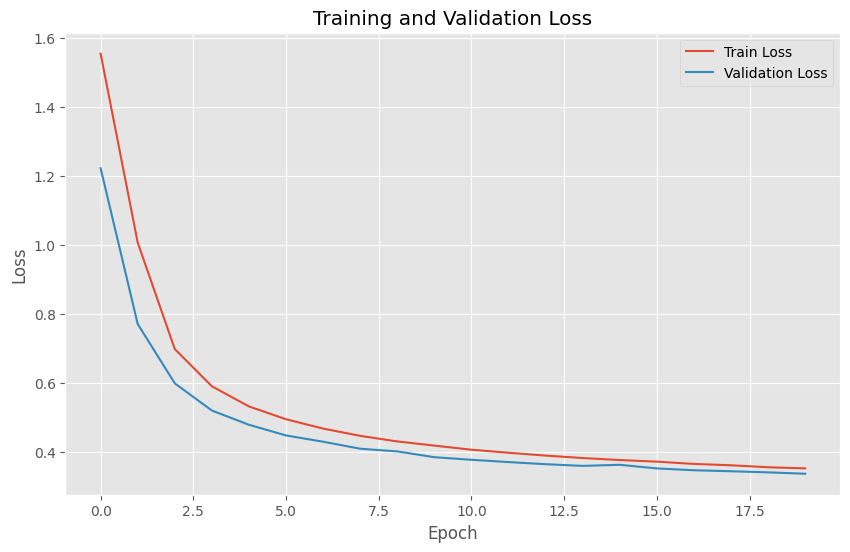

In [ ]:
# 학습 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 2.5. 분자 생성 예제

In [ ]:
# 최적 모델 로드
def load_checkpoint(model, filename):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"모델 로드: {filename}, Epoch: {checkpoint['epoch']}, Loss: {checkpoint['loss']:.4f}")
    else:
        print(f"체크포인트 파일을 찾을 수 없습니다: {filename}")
    return model

model = load_checkpoint(model, 'best_model.pt')
model.eval()

모델 로드: best_model.pt, Epoch: 19, Loss: 0.3382


SMILESGenerator(
  (embedding): Embedding(37, 64)
  (lstm): LSTM(64, 256, num_layers=3, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=37, bias=True)
)


온도 매개변수: 0.5


<ipython-input-21-a8e6c32a9fdb>:28: RuntimeWarning: invalid value encountered in log
  output_probs = np.log(output_probs + 1e-10) / temperature


생성된 분자 수: 100
유효한 분자 수: 100
유효성 비율: 100.00%

분자 특성 요약:
              MolWt          LogP          TPSA    HBD    HBA  RotBonds  \
count  1.000000e+02  1.000000e+02  1.000000e+02  100.0  100.0     100.0   
mean   3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
std    3.427787e-13  2.677959e-15  4.284734e-14    0.0    0.0       0.0   
min    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
25%    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
50%    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
75%    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
max    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   

       Lipinski_Violations  
count                100.0  
mean                   0.0  
std                    0.0  
min                    0.0  
25%                    0.0  
50%                    0.0  
75%                    0.0  
max                    0.0  


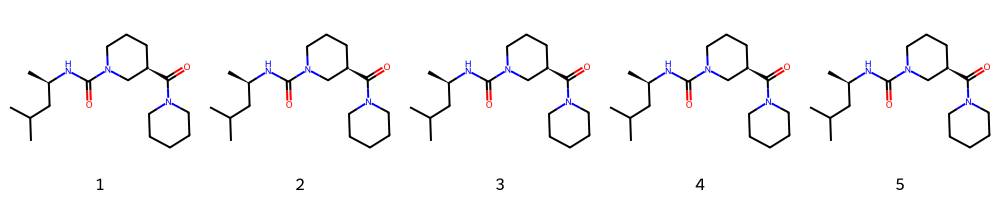


온도 매개변수: 0.7


<ipython-input-21-a8e6c32a9fdb>:28: RuntimeWarning: invalid value encountered in log
  output_probs = np.log(output_probs + 1e-10) / temperature


생성된 분자 수: 100
유효한 분자 수: 100
유효성 비율: 100.00%

분자 특성 요약:
              MolWt          LogP          TPSA    HBD    HBA  RotBonds  \
count  1.000000e+02  1.000000e+02  1.000000e+02  100.0  100.0     100.0   
mean   3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
std    3.427787e-13  2.677959e-15  4.284734e-14    0.0    0.0       0.0   
min    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
25%    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
50%    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
75%    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
max    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   

       Lipinski_Violations  
count                100.0  
mean                   0.0  
std                    0.0  
min                    0.0  
25%                    0.0  
50%                    0.0  
75%                    0.0  
max                    0.0  


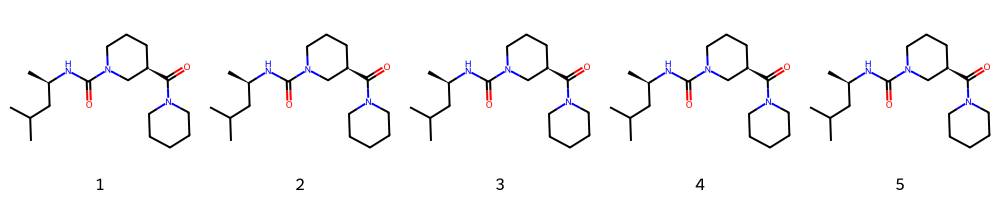


온도 매개변수: 1.0


<ipython-input-21-a8e6c32a9fdb>:28: RuntimeWarning: invalid value encountered in log
  output_probs = np.log(output_probs + 1e-10) / temperature


생성된 분자 수: 100
유효한 분자 수: 100
유효성 비율: 100.00%

분자 특성 요약:
              MolWt          LogP          TPSA    HBD    HBA  RotBonds  \
count  1.000000e+02  1.000000e+02  1.000000e+02  100.0  100.0     100.0   
mean   3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
std    3.427787e-13  2.677959e-15  4.284734e-14    0.0    0.0       0.0   
min    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
25%    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
50%    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
75%    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
max    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   

       Lipinski_Violations  
count                100.0  
mean                   0.0  
std                    0.0  
min                    0.0  
25%                    0.0  
50%                    0.0  
75%                    0.0  
max                    0.0  


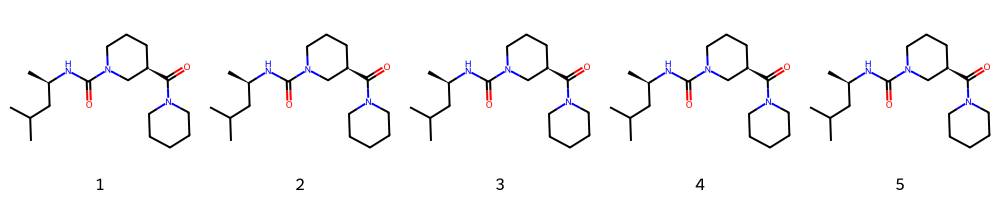


온도 매개변수: 1.2


<ipython-input-21-a8e6c32a9fdb>:28: RuntimeWarning: invalid value encountered in log
  output_probs = np.log(output_probs + 1e-10) / temperature


생성된 분자 수: 100
유효한 분자 수: 100
유효성 비율: 100.00%

분자 특성 요약:
              MolWt          LogP          TPSA    HBD    HBA  RotBonds  \
count  1.000000e+02  1.000000e+02  1.000000e+02  100.0  100.0     100.0   
mean   3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
std    3.427787e-13  2.677959e-15  4.284734e-14    0.0    0.0       0.0   
min    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
25%    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
50%    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
75%    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   
max    3.234810e+02  2.855100e+00  5.265000e+01    1.0    2.0       4.0   

       Lipinski_Violations  
count                100.0  
mean                   0.0  
std                    0.0  
min                    0.0  
25%                    0.0  
50%                    0.0  
75%                    0.0  
max                    0.0  


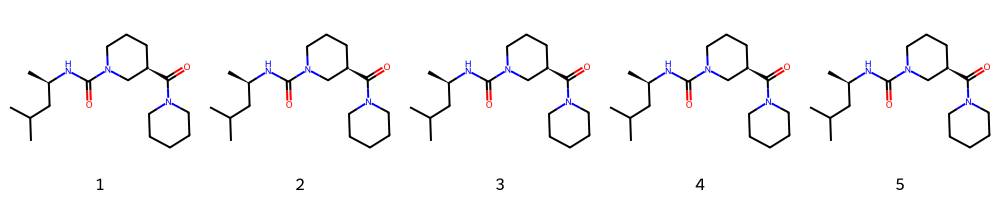

In [ ]:
# 분자 생성 함수
def generate_smiles(model, char_to_idx, idx_to_char, start_char='<', max_length=100, temperature=1.0):
    """훈련된 모델을 사용하여 SMILES 문자열 생성"""
    model.eval()

    # 초기 시퀀스 시작 (시작 토큰)
    generated = start_char
    input_idx = char_to_idx[start_char]

    # 은닉 상태 초기화
    hidden = model.init_hidden(1)

    # 다음 문자 예측 및 생성
    with torch.no_grad():
        for _ in range(max_length):
            # 입력 텐서 준비
            input_tensor = torch.tensor([[input_idx]], dtype=torch.long).to(device)

            # 다음 문자 예측
            output, hidden = model(input_tensor, hidden)

            # 출력에서 다음 문자 확률 가져오기
            output_probs = output[0, -1].cpu().numpy()

            # 온도 매개변수를 사용하여 다양성 조정
            try:
                # 수치 안정성을 위해 더 작은 값 추가
                output_probs = np.log(output_probs + 1e-10) / temperature
                exp_preds = np.exp(output_probs)
                output_probs = exp_preds / np.sum(exp_preds)

                # NaN 값 확인 및 처리
                if np.isnan(output_probs).any() or np.sum(output_probs) == 0:
                    # 극단적인 값이 있을 경우 소프트맥스 대신 argmax 사용
                    next_idx = np.argmax(output[0, -1].cpu().numpy())
                else:
                    # 다음 문자 샘플링
                    next_idx = np.random.choice(len(output_probs), p=output_probs)
            except:
                # 오류 발생 시 가장 확률이 높은 문자 선택
                next_idx = np.argmax(output[0, -1].cpu().numpy())

            next_char = idx_to_char[next_idx]

            # 생성된 문자열에 추가
            generated += next_char
            input_idx = next_idx

            # 종료 토큰이 나오면 생성 종료
            if next_char == '>':
                break

    # 시작 및 종료 토큰 제거
    return generated.strip('<>')

# 여러 분자 생성
def generate_multiple_smiles(model, char_to_idx, idx_to_char, n=10, temperature=1.0):
    """여러 SMILES 문자열 생성"""
    generated_smiles = []

    for _ in range(n):
        smile = generate_smiles(model, char_to_idx, idx_to_char, temperature=temperature)
        generated_smiles.append(smile)

    return generated_smiles

# 생성된 분자 유효성 확인
def check_validity(smiles_list):
    """생성된 SMILES의 유효성 확인"""
    valid_mols = []
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
            valid_mols.append((smile, mol))

    validity_ratio = len(valid_mols) / len(smiles_list) if smiles_list else 0
    return valid_mols, validity_ratio

# 분자 특성 계산
def calculate_properties(mols):
    """분자의 다양한 특성 계산"""
    properties = []

    for smile, mol in mols:
        # 기본 특성 계산
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        tpsa = Descriptors.TPSA(mol)
        h_donors = Lipinski.NumHDonors(mol)
        h_acceptors = Lipinski.NumHAcceptors(mol)
        rotatable_bonds = Descriptors.NumRotatableBonds(mol)

        # Lipinski 규칙 검사
        lipinski_violations = 0
        if mw > 500: lipinski_violations += 1
        if logp > 5: lipinski_violations += 1
        if h_donors > 5: lipinski_violations += 1
        if h_acceptors > 10: lipinski_violations += 1

        properties.append({
            'SMILES': smile,
            'MolWt': mw,
            'LogP': logp,
            'TPSA': tpsa,
            'HBD': h_donors,
            'HBA': h_acceptors,
            'RotBonds': rotatable_bonds,
            'Lipinski_Violations': lipinski_violations
        })

    return pd.DataFrame(properties)

# 분자 생성 및 분석
num_molecules = 100
temperature_values = [0.5, 0.7, 1.0, 1.2]

results = {}

for temp in temperature_values:
    print(f"\n온도 매개변수: {temp}")

    # 분자 생성
    generated_smiles = generate_multiple_smiles(model, char_to_idx, idx_to_char, n=num_molecules, temperature=temp)

    # 유효성 검사
    valid_mols, validity_ratio = check_validity(generated_smiles)
    print(f"생성된 분자 수: {len(generated_smiles)}")
    print(f"유효한 분자 수: {len(valid_mols)}")
    print(f"유효성 비율: {validity_ratio:.2%}")

    # 특성 계산
    if valid_mols:
        props_df = calculate_properties(valid_mols)
        results[temp] = {
            'smiles': generated_smiles,
            'valid_mols': valid_mols,
            'validity_ratio': validity_ratio,
            'properties': props_df
        }

        # 특성 요약
        print("\n분자 특성 요약:")
        print(props_df.describe())

        # 일부 분자 시각화
        if len(valid_mols) >= 5:
            mols_to_draw = [mol for _, mol in valid_mols[:5]]
            img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(200, 200), legends=[f"{i+1}" for i in range(5)])
            display(img)